In [1]:
# imports and functions, does nothing

from functools import partial
from IPython.display import Image, display, Video, Image, HTML
from matplotlib import rcParams
from prettytable import PrettyTable
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.multiclass import unique_labels
import sys
sys.path.append('../..')
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import pathlib
import random
import sklearn
import random
import matplotlib
matplotlib.rcParams.update({'font.size': 14})


def img(path, width=400):
    rnd = random.randint(0,2e9)
    return f"""<img src="{path}?nocache={rnd}" style="width:{width}px; "></img>"""


In [2]:
data_all = np.load('quic-100p-338-40-loops-har.npy', allow_pickle=True).item()
data = data_all['both'] # adblock + decentraleyes
urls = [url for url in data]

In [3]:
number_of_subresources = []
for url in urls:
    n_subresources = [len(data[url][sample]) for sample in data[url]]
    if np.mean(n_subresources) == 0:
        continue
    number_of_subresources.append([url, np.mean(n_subresources)])

number_of_subresources.sort(key=lambda row: row[1])

url_min_subresources = number_of_subresources[0]
url_max_subresources = number_of_subresources[-1]

print("Min", url_min_subresources)
print("Max", url_max_subresources)
#print(number_of_subresources)

#print(data['autohubgroup.com'])


Min ['vliplatform.com', 1.0]
Max ['autohubgroup.com', 154.33333333333334]


[0.         0.11949686 0.04402516 0.01572327 0.02201258 0.02201258
 0.00943396 0.02201258 0.01572327 0.02830189 0.02201258 0.02515723
 0.01886792 0.01572327 0.02201258 0.02515723 0.01886792 0.02515723
 0.02201258 0.01886792 0.02201258 0.01257862 0.01572327 0.02201258
 0.01572327 0.01572327 0.01572327 0.00628931 0.01257862 0.02201258
 0.01572327 0.00628931 0.01257862 0.00943396 0.01257862 0.00314465
 0.00943396 0.00628931 0.00943396 0.00943396 0.00628931 0.00628931
 0.         0.00943396 0.00943396 0.01257862 0.         0.01886792
 0.01572327 0.00943396 0.00943396 0.00628931 0.         0.
 0.00314465 0.         0.00314465 0.00628931 0.00314465 0.00314465
 0.00314465 0.00943396 0.         0.00628931 0.00314465 0.00628931
 0.         0.         0.00628931 0.00314465 0.00628931 0.
 0.00314465 0.00628931 0.         0.00628931 0.         0.
 0.         0.00628931 0.00314465 0.         0.         0.
 0.         0.         0.         0.00314465 0.         0.
 0.00628931 0.00628931 0.         0

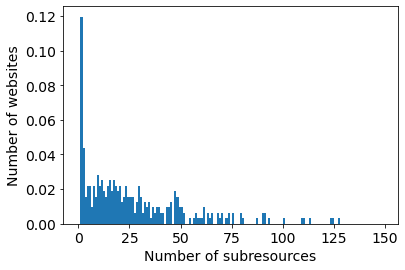

In [4]:
ys = [row[1] for row in number_of_subresources]

res = plt.hist(ys, bins=np.arange(0, 150, 1), density=True)
plt.xlabel("Number of subresources")
plt.ylabel("Number of websites")

print(res[0])
print(sum(res[0]))

There are 38 websites which load <= 2 subresources.


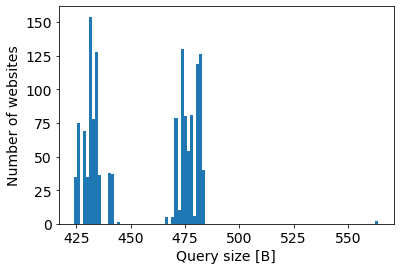

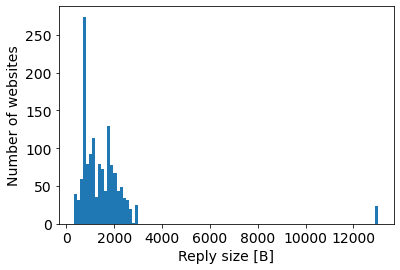

In [5]:
# Have a look only at websites who have less than X subresources
X = 2

urls_less_than_X = [row[0] for row in number_of_subresources if row[1] < X]

print(f"There are {len(urls_less_than_X)} websites which load <= {X} subresources.")

query_sizes = []
reply_sizes = []

for url in urls_less_than_X:
    samples = data[url]
    for sample in samples:
        t, up, down = data[url][sample][0] # first request
        if up > 0:
            query_sizes.append(up)
        if down > 0:
            reply_sizes.append(down)

res = plt.hist(query_sizes, bins=100)
plt.xlabel("Query size [B]")
plt.ylabel("Number of websites")
plt.show()

res = plt.hist(reply_sizes, bins=100)
plt.xlabel("Reply size [B]")
plt.ylabel("Number of websites")
plt.show()

There are 95 websites which load <= 10 subresources.


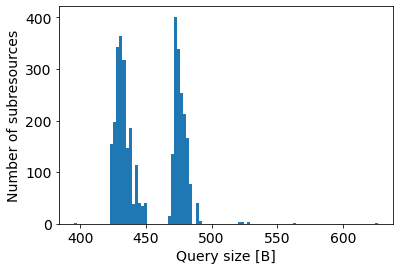

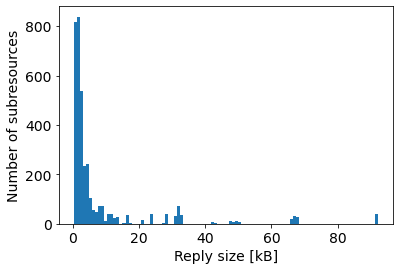

In [6]:
# Have a look only at websites who have exactly X subresources
X = 10

urls_less_than_X = [row[0] for row in number_of_subresources if row[1] <= X]

print(f"There are {len(urls_less_than_X)} websites which load <= {X} subresources.")

query_sizes = []
reply_sizes = []

for url in urls_less_than_X:
    samples = data[url]
    for sample in samples:
        t, up, down = data[url][sample][0] # first request
        if up > 0:
            query_sizes.append(up)
        if down > 0:
            reply_sizes.append(down/1024)

res = plt.hist(query_sizes, bins=100)
plt.xlabel("Query size [B]")
plt.ylabel("Number of subresources")
plt.show()

res = plt.hist(reply_sizes, bins=100)
plt.xlabel("Reply size [kB]")
plt.ylabel("Number of subresources")
plt.show()

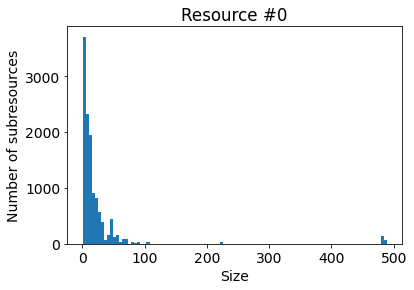

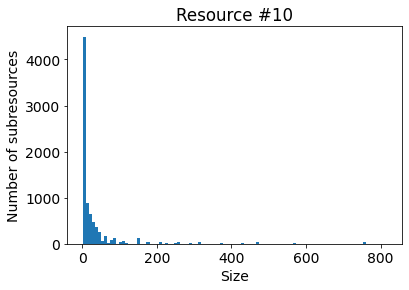

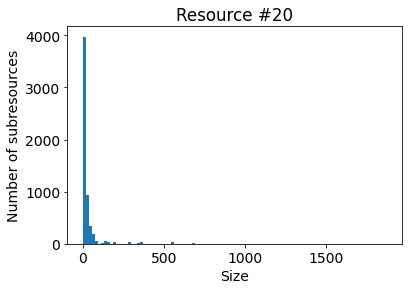

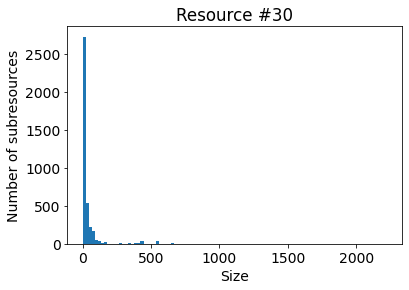

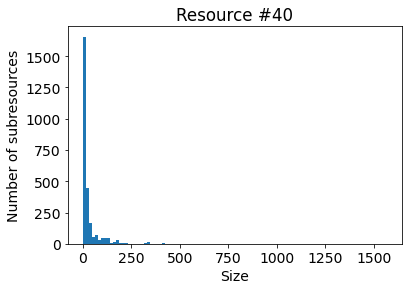

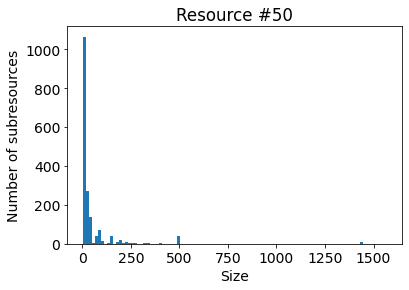

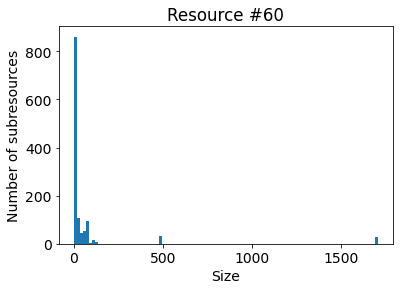

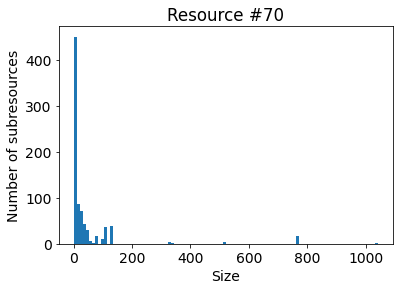

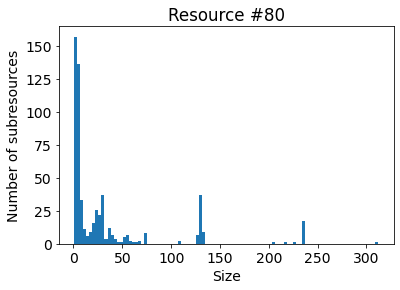

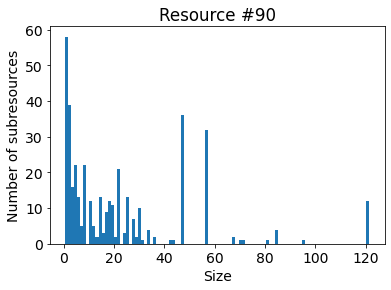

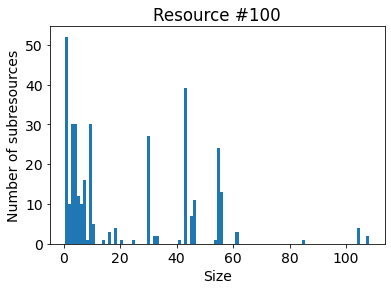

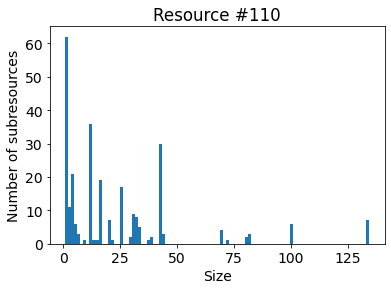

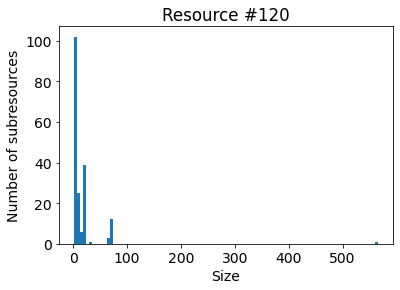

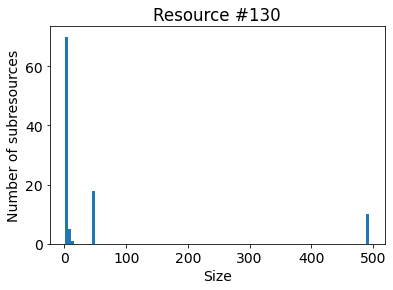

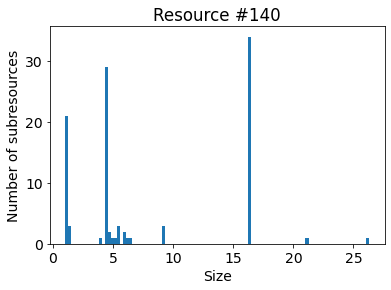

In [7]:
# are the sizes dependend on the subresource ID (position) ?
# upstream: no, between 400B and 600B
# downstream: not really, inverse-hockeystick

for subresource_pos in range(0, 150, 10):

    query_sizes = []
    reply_sizes = []

    for url in urls:
        samples = data[url]
        for sample in samples:

            if len(data[url][sample]) <= subresource_pos:
                continue

            t, up, down = data[url][sample][subresource_pos] # first request
            if up > 0:
                query_sizes.append(up)
            if down > 0:
                reply_sizes.append(down/1024)

    res = plt.hist(reply_sizes, bins=100)
    plt.xlabel("Size")
    plt.ylabel("Number of subresources")
    plt.title(f"Resource #{subresource_pos}")
    plt.show()

In [8]:
import numpy as np
import math
import sys
import random

def average(array):
    if array is None or len(array) == 0:
        return 0
    return np.average(array)

def array_to_fix_size(array, length, pad_with=0):
    if len(array) < length:
        array.extend([pad_with] * (length - len(array)))
    elif len(array) > length:
        array = array[:length]
    return array

def split_in_chunks(array, num_splits):
    avg = len(array) / float(num_splits)
    out = []
    last = 0.0
    while last < len(array):
        out.append(array[int(last): int(last + avg)])
        last += avg
    return out

def get_packet_inter_times(data):
    if len(data) == 0:
        return [0]
    times = [x[0] for x in data]
    result = []
    for elem, next_elem in zip(times, times[1:] + [times[0]]):
        result.append(next_elem - elem)
    return result[:-1]

def add_intertimes_stats(features, data, incoming, outgoing):
    # statistics about the inter-packet durations

    def add_stats(trace, prefix=''):
        if trace is not None and len(trace) > 0:
            features['intertime_'+prefix+'max'] = max(trace)
            features['intertime_'+prefix + 'avg'] = average(trace)
            features['intertime_'+prefix+'std'] = np.std(trace)
            features['intertime_'+prefix+'p75'] = np.percentile(trace, 75)
        else:
            features['intertime_'+prefix+'p25'] = 0
            features['intertime_'+prefix+'p50'] = 0
            features['intertime_'+prefix+'p75'] = 0
            features['intertime_'+prefix+'p100'] = 0

    incoming_intertimes = get_packet_inter_times(incoming)
    outgoing_intertimes = get_packet_inter_times(outgoing)
    all_intertimes = get_packet_inter_times(data)

    add_stats(incoming_intertimes, 'incoming_')
    add_stats(outgoing_intertimes, 'outgoing_')
    add_stats(all_intertimes, '')


def add_time_percentiles(features, data, incoming, outgoing):
    # percentiles about the times in which packets where sent/received

    def add_percentiles(trace, prefix=''):
        if trace is not None and len(trace) > 0:
            features['time_'+prefix+'p25'] = np.percentile(trace, 25)
            features['time_'+prefix+'p50'] = np.percentile(trace, 50)
            features['time_'+prefix+'p75'] = np.percentile(trace, 75)
            features['time_'+prefix+'p100'] = np.percentile(trace, 100)
        else:
            features['time_'+prefix+'p25'] = 0
            features['time_'+prefix+'p50'] = 0
            features['time_'+prefix+'p75'] = 0
            features['time_'+prefix+'p100'] = 0

    incoming_times = [x[0] for x in incoming]
    outgoing_times = [x[0] for x in outgoing]
    times = [x[0] for x in data]

    add_percentiles(incoming_times, 'incoming_')
    add_percentiles(outgoing_times, 'outgoing_')
    add_percentiles(times, '')

    features['times_sum'] = sum(times)


def add_counts_in_out_last_first_30(features, data):
    # counts (incoming, outgoing) packets in the (first, last) 30 packets

    # NB: these features don't make much sense for HARs

    first30 = data[:30]
    last30 = data[-30:]
    first30in = []
    first30out = []
    for p in first30:
        if p[1] > 0: 
            first30in.append(p)
        if p[2] >= 0:
            first30out.append(p)
    last30in = []
    last30out = []
    for p in last30:
        if p[1] > 0:
            last30in.append(p)
        if p[2] >= 0:
            last30out.append(p)

    features['f30_n_incoming'] = len(first30in)
    features['f30_n_outgoing'] = len(first30out)
    features['l30_n_incoming'] = len(last30in)
    features['l30_n_outgoing'] = len(last30out)


def add_outgoing_concentrations_stats(features, data):
    # concentration of outgoing packets in chunks of 20 packets

    chunks = [data[x: x + 20] for x in range(0, len(data), 20)]
    concentrations = []
    for item in chunks:
        c = 0
        for p in item:
            if p[2] >= 0: # outgoing packets
                c += 1
        concentrations.append(c)

    concentrations = array_to_fix_size(concentrations, 40)

    features['outgoing_concentrations_std'] = np.std(concentrations)
    features['outgoing_concentrations_mean'] = average(concentrations)
    features['outgoing_concentrations_p50'] = np.percentile(concentrations, 50)
    features['outgoing_concentrations_min'] = min(concentrations)
    features['outgoing_concentrations_max'] = max(concentrations)

    i = 0
    while i < len(concentrations):
        features['outgoing_concentrations_'+str(i)] = concentrations[i]
        i += 1

    # Same think, but for trace divided in 70 fixed chunks

    outgoing_concentrations_70 = [
        sum(x) for x in split_in_chunks(concentrations, 70)]

    i = 0
    while i < len(outgoing_concentrations_70):
        features['outgoing_concentrations_70_' +
                 str(i)] = outgoing_concentrations_70[i]
        i += 1

    features['outgoing_concentrations_70_sum'] = sum(
        outgoing_concentrations_70)


def add_delta_rates_stats(features, data):
    # Average number packets sent and received per second

    last_time = data[-1][1]
    last_second = math.ceil(last_time)

    count_per_sec = []
    for sec in range(1, int(last_second) + 1):
        count = 0
        for p in data:
            if p[0] <= sec: # p[0] is packet time
                count += 1
        count_per_sec.append(count)

    count_per_sec = array_to_fix_size(count_per_sec, 10)

    delta_count_per_sec = [0]  # first difference is 0
    i = 1
    while i < len(count_per_sec):
        diff = count_per_sec[i] - count_per_sec[i-1]
        delta_count_per_sec.append(diff)
        i += 1

    features['delta_rate_avg'] = average(delta_count_per_sec)
    features['delta_rate_std'] = np.std(delta_count_per_sec)
    features['delta_rate_p50'] = np.percentile(delta_count_per_sec, 50)
    features['delta_rate_min'] = min(delta_count_per_sec)
    features['delta_rate_max'] = max(delta_count_per_sec)

    i = 1
    while i < len(delta_count_per_sec):
        features['delta_rate_'+str(i)] = delta_count_per_sec[i]
        i += 1

    # Same thing, but trace divided in 20 fixed chunks

    delta_counts_20 = [sum(x)
                       for x in split_in_chunks(delta_count_per_sec, 20)]

    i = 0
    while i < len(delta_counts_20):
        features['delta_rates_20_'+str(i)] = delta_counts_20[i]
        i += 1

    features['delta_rates_20_sum'] = sum(delta_counts_20)


def extract_features(data, max_size=123):
    features = dict()


    if len(data) == 0:
        return array_to_fix_size([], max_size, pad_with=('*', 0))

    def quic_to_1(s):
        if s=='quic':
            return 1
        return 0

    outgoing = [pkt for pkt in data if pkt[1] > 0]
    incoming = [pkt for pkt in data if pkt[2] > 0]

    features['n_incoming'] = len(incoming)
    features['n_outgoing'] = len(outgoing)
    features['n_total'] = len(data)
    features['%_in'] = len(incoming) / float(len(data))
    features['%_out'] = len(outgoing) / float(len(data))
    
    features['bytes_incoming'] = sum([d[2] for d in incoming])
    features['bytes_outgoing'] = sum([d[1] for d in outgoing])
    features['bytes_total'] = features['bytes_incoming'] + features['bytes_outgoing']
    if features['bytes_total'] > 0:
        features['bytes_%_in'] = features['bytes_incoming'] / float(features['bytes_total'])
        features['bytes_%_out'] = features['bytes_outgoing'] / float(features['bytes_total'])
    else:
        features['bytes_%_in'] = 0
        features['bytes_%_out'] = 0

    add_intertimes_stats(features, data, incoming, outgoing)
    add_time_percentiles(features, data, incoming, outgoing)
    add_counts_in_out_last_first_30(features, data)

    add_delta_rates_stats(features, data)

    # added size features; TLS max is -16K +16k
    incoming_sizes = [x[2] for x in incoming]
    bins = np.linspace(0, 16*1024, 50)
    hist, bin_edges = np.histogram(incoming_sizes, bins=bins, density=False)

    i = 0
    while i < len(hist):
        features['hist_'+str(round(bin_edges[i]))] = hist[i]
        i += 1

    # unmap feature dictionnary for padding
    tuples = [(k, v) for k, v in features.items()]

    features = array_to_fix_size(tuples, max_size, pad_with=('*', 0))

    return features

def trace_starts_at_time0(X):

    if len(X) == 0:
        return X

    t0 = X[0][0]
    i = 0
    while i<len(X):
        X[i][0] -= t0
        i += 1

    return X

def get_features(hars):
    result = dict(feature_names=None, feature=[], label=[])

    result = dict()
    result['feature_names'] = None
    result['features'] = [] #X
    result['labels'] = [] #y

    for i, url in enumerate(hars):
        samples = hars[url]
        empty_samples = [s for s in samples if len(samples[s]) == 0]

        if len(samples) < 20:
            print("Skipping", url, "only", len(samples), "samples")
            continue

        if len(empty_samples) > 5:
            print("Skipping", url, ",", len(empty_samples), "empty samples")
            continue

        for sample_id in samples:
            X = samples[sample_id]

            X = trace_starts_at_time0(X)
            f = extract_features(X)

            feature_names = [x[0] for x in f]
            feature_values = [x[1] for x in f]

            if result['feature_names'] is None:
                result['feature_names'] = feature_names
            result['features'].append(feature_values)
            result['labels'].append([url, sample_id])

    print("[feature_extract] Number of classes", len(set([y[0] for y in result['labels']])))
    print("[feature_extract] Number of features", len(result['features'][0]))
    print("[feature_extract] Number of samples", len(result['features']))
    print("[feature_extract] Number of labels", len(result['labels']))

    return result


In [9]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn import metrics
import random
import sys
import pathlib
from sklearn.feature_selection import RFE
from functools import partial
import pandas
import sklearn
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

def random_forest(features_names, X_train, y_train, X_test, y_test, n_trees, rfe_nfeatures, rfe_steps=10):
    clf=RandomForestClassifier(n_jobs=-1, n_estimators=n_trees, random_state=0)
    
    selector = RFE(estimator=clf, n_features_to_select=rfe_nfeatures, step=rfe_steps)

    selector = selector.fit(X_train, y_train)
    X_train = selector.transform(X_train)
    X_test = selector.transform(X_test)
    
    clf2=RandomForestClassifier(n_jobs=-1, n_estimators=n_trees, random_state=0)
    clf2.fit(X_train, y_train)
    y_pred=clf2.predict(X_test)
    predicted_probas = clf2.predict_proba(X_test)

    scores = dict(
        accuracy = metrics.accuracy_score(y_test, y_pred),
        precision = metrics.precision_score(y_test, y_pred, average='micro'),
        recall = metrics.recall_score(y_test, y_pred, average='micro'),
        f1score = metrics.f1_score(y_test, y_pred, average='micro'),
    )
    selected_features = []
    i = 0
    while i<len(features_names):
        if selector.support_[i] == 1:
            selected_features.append(features_names[i])
        i+=1

    feature_importance = sorted(zip(clf2.feature_importances_, selected_features), reverse=True)

    return scores, feature_importance, y_pred, predicted_probas


def rf_folds(X, y, feature_names, rfe_nfeatures=10, rfe_steps=100, n_trees=30, folds=10, test_size=0.2):
    sss = StratifiedShuffleSplit(n_splits=folds, test_size=test_size, random_state=0)

    print("Number of classes", len(set(y)))
    print("Number of features", len(X[0]))
    print("Number of samples", len(X))
    print("Number of labels", len(y))

    scores = []
    y_test_all = []
    y_pred_all = []
    feature_ranks = dict()

    i = 0
    for train_index, test_index in sss.split(X, y):
        print("Fold", i)

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        s, features, y_pred, _  = random_forest(feature_names, X_train, y_train, X_test, y_test, n_trees=n_trees, rfe_nfeatures=rfe_nfeatures, rfe_steps=rfe_steps)

        y_test_all.extend(y_test) 
        y_pred_all.extend(y_pred.tolist())
        
        for proba, feature in features:
            if not feature in feature_ranks:
                feature_ranks[feature] = []

            feature_ranks[feature].append(proba)

        scores.append(s)
        i += 1

    # average scores
    score = {k: (np.mean([value[k] for value in scores]), np.std([value[k] for value in scores])) for k in scores[0]}

    # average features importance
    for f in feature_ranks:
        if len(feature_ranks[f]) < folds:
            feature_ranks[f].extend([0] * (folds - len(feature_ranks[f])))

    features_and_percentages = []
    for f in feature_ranks:
        features_and_percentages.append((f, np.mean(feature_ranks[f]), np.std(feature_ranks[f])))
        

    return score, features_and_percentages, y_test_all, y_pred_all


def labels_strings_to_ids(labels):
    mapping = dict()
    i = 0
    for l in labels:
        if l in mapping:
            continue
        mapping[l] = i
        i += 1
    
    labels2 = [mapping[l] for l in labels]

    return labels2, mapping


def rf_with_rfe(features_array):
    feature_names = features_array["feature_names"]
    X = np.array(features_array["features"])
    Y = np.array(features_array["labels"])
    y_str = np.array([label[0] for label in Y])
    score, features_and_percentages, y_test_all, y_pred_all = rf_folds(X, y_str, feature_names)

    return dict(score=score, features=features_and_percentages)


In [10]:
data_short = {}
for url in data:
    data_short[url] = data[url]
    if len(data_short) == 10:
        break

In [11]:
# Have a look only at websites who have exactly X subresources
for X in range(0, 150,1):
    urls_matching = [row[0] for row in number_of_subresources if round(row[1]) == X]

    print(f"There are {len(urls_matching)} websites which load == {X} subresources.")



There are 0 websites which load == 0 subresources.
There are 34 websites which load == 1 subresources.
There are 10 websites which load == 2 subresources.
There are 11 websites which load == 3 subresources.
There are 7 websites which load == 4 subresources.
There are 7 websites which load == 5 subresources.
There are 2 websites which load == 6 subresources.
There are 8 websites which load == 7 subresources.
There are 5 websites which load == 8 subresources.
There are 3 websites which load == 9 subresources.
There are 12 websites which load == 10 subresources.
There are 10 websites which load == 11 subresources.
There are 3 websites which load == 12 subresources.
There are 5 websites which load == 13 subresources.
There are 10 websites which load == 14 subresources.
There are 8 websites which load == 15 subresources.
There are 6 websites which load == 16 subresources.
There are 7 websites which load == 17 subresources.
There are 5 websites which load == 18 subresources.
There are 6 webs

In [12]:
X = 12
urls_len_matching = [row for row in number_of_subresources if round(row[1]) == 2]
urls_matching = [row[0] for row in urls_len_matching]
print(f"There are {len(urls_matching)} websites which load == {X} subresources.")

data_matching = dict()
for row in urls_len_matching:
    url, count = row
    data_matching[url] = data[url]
    print(url, count)

There are 10 websites which load == 12 subresources.
canadagoosebuy.ca 1.5384615384615385
smileytoysandgames.com 1.725
apiexpossandbox.mile.app 1.75
publyads.jstag.space 1.775
cialisdr.com 2.0
viaagra1.com 2.051282051282051
muk-toon.com 2.175
myegypthost.com 2.388888888888889
venona.com 2.41025641025641
www.thaitoon.net 2.4210526315789473


In [13]:
features = get_features(data_matching)

[feature_extract] Number of classes 10
[feature_extract] Number of features 123
[feature_extract] Number of samples 391
[feature_extract] Number of labels 391


In [14]:
res = rf_with_rfe(features)
print(res)

Number of classes 10
Number of features 123
Number of samples 391
Number of labels 391
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
{'score': {'accuracy': (0.9746835443037976, 0.017901437498393607), 'precision': (0.9746835443037976, 0.017901437498393607), 'recall': (0.9746835443037976, 0.017901437498393607), 'f1score': (0.9746835443037976, 0.017901437498393607)}, 'features': [('bytes_outgoing', 0.1817622585671093, 0.010743071734856531), ('bytes_incoming', 0.11932084996442938, 0.0162116330518129), ('bytes_%_out', 0.11960977528698555, 0.012190372814518586), ('bytes_%_in', 0.1246990433439914, 0.013051697833411634), ('bytes_total', 0.12531039378967296, 0.004881839143253002), ('hist_2675', 0.06703958871130329, 0.005677335775290474), ('intertime_outgoing_p25', 0.04031584965978187, 0.03343762517424351), ('intertime_incoming_p25', 0.07057856392743714, 0.024867312445047713), ('hist_2006', 0.060054305067388944, 0.005100094973449563), ('hist_1672', 0.0541341408785367, 0.0

([<matplotlib.axis.XTick at 0x7fe22ec5bcd0>,
 [Text(0, 0, 'can'),
  Text(1, 0, 'cia'),
  Text(2, 0, 'muk'),
  Text(3, 0, 'api'),
  Text(4, 0, 'www'),
  Text(5, 0, 'ven'),
  Text(6, 0, 'pub'),
  Text(7, 0, 'smi'),
  Text(8, 0, 'mye'),
  Text(9, 0, 'via')])

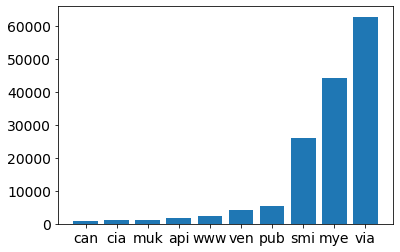

In [15]:
incoming_bytes = []
incoming_bytes_per_website = dict()

for url in data_matching:
    incoming_bytes_for_this_website = []

    for sample in data[url]:
        for request in data[url][sample]:
            t, out, inc = request
            incoming_bytes.append(abs(inc))
            incoming_bytes_for_this_website.append(abs(inc))

    incoming_bytes_per_website[url] = np.mean(incoming_bytes_for_this_website)

tuples = list(incoming_bytes_per_website.items())
tuples.sort(key=lambda row: row[1])

xs = [t[0][:3] for t in tuples]
ys = [int(t[1]) for t in tuples]

plt.bar(np.arange(len(ys)), ys)
plt.xticks(np.arange(len(ys)), xs)
#plt.yscale('log')
#plt.ylim([0, 10000])

In [17]:
incoming_bytes.sort()
incoming_bytes = [x for x in incoming_bytes if x > 2] # 0 and 1 are special case that correspond to blocked resources

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def find_cost(data, padding_function_steps):
    costs = []
    for x in data:
        i = 0
        pad_to = padding_function_steps[i]
        while x > pad_to:
            i += 1
            pad_to = padding_function_steps[i]
        costs.append(pad_to - x)
    return costs


def find_optimal_pad(data, n_cut): # data must be sorted
    size_of_cut = math.ceil(len(data) / n_cut)
    chunked = chunks(data, size_of_cut)
    cuts = [chunk[-1] for chunk in chunked]
    costs = find_cost(data, cuts)

    return cuts, np.mean(costs)

print(incoming_bytes[-3:])

padding_functions = None
if os.path.isfile('padding_functions.X=10.tmp.npy'):
    padding_functions = np.load('padding_functions.X=10.tmp.npy', allow_pickle=True)

if padding_functions is None:
    padding_functions = []
    for cut in range(1, 200):
        cuts, mean_cost = find_optimal_pad(incoming_bytes, cut)
        padding_functions.append([cuts, mean_cost])
        print(mean_cost, cuts)

    np.save('padding_functions.X=10.tmp.npy', padding_functions, allow_pickle=True)

for cut, mean_cost in padding_functions:
    print(mean_cost, cut)


[169102, 169128, 169136]
153261.13624338625 [169136]
69623.63624338624 [1861, 169136]
41154.35978835979 [979, 2302, 169136]
27376.25529100529 [858, 1861, 2919, 169136]
19555.64814814815 [834, 1264, 2094, 2967, 169128, 169136]
17863.660052910054 [819, 979, 1861, 2302, 27745, 169136]
14148.080687830688 [798, 877, 1704, 2052, 2603, 35778, 169136]
11513.732804232804 [763, 857, 1264, 1861, 2106, 2916, 35786, 169098, 169136]
10637.223544973545 [751, 840, 979, 1738, 1998, 2302, 2954, 57937, 169136]
9218.705026455027 [749, 834, 884, 1264, 1853, 2092, 2603, 2963, 57953, 169094, 169136]
10706.095238095239 [746, 830, 867, 1264, 1742, 1919, 2110, 2603, 23247, 71733, 169090, 169136]
7995.5026455026455 [745, 819, 858, 979, 1461, 1861, 2080, 2302, 2919, 27745, 76372, 169136]
8678.935185185184 [744, 814, 844, 892, 1264, 1746, 1915, 2098, 2603, 2933, 35744, 93775, 169102, 169136]
6654.0026455026455 [743, 798, 837, 877, 1264, 1704, 1861, 2052, 2246, 2603, 2960, 35778, 93946, 169136]
6381.706349206349 [7

/usr/lib64/python3.9/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [18]:
def next_val(x, padding_function_steps):
    i = 0
    pad_to = padding_function_steps[i]
    while x > pad_to:
        i += 1
        if i >= len(padding_function_steps):
            print(x, padding_function_steps)
        pad_to = padding_function_steps[i]
    return padding_function_steps[i]


def pad_to_cuts(data, cuts):
    data2 = {}
    for url in data:
        data2[url] = {}
        for sample in data[url]:
            data2[url][sample] = []
            for request in data[url][sample]:
                t, out, inc = request
                out = 600 # pad all requests
                data2[url][sample].append([t, out, next_val(inc, cuts)])
    return data2

clf_perf = None
if os.path.isfile('clf_perfs.X=10.tmp.npy'):
    clf_perf = np.load('clf_perfs.X=10.tmp.npy', allow_pickle=True).item()

if clf_perf is None:
    clf_perf = {}
    for cuts, mean_cost in padding_functions:
        print(f"***************** Working on n cuts: {len(cuts)}")
        data_padded = pad_to_cuts(data_matching, cuts)
        features = get_features(data_padded)
        clf_res = rf_with_rfe(features)

        clf_perf[len(cuts)] = clf_res
    np.save('clf_perfs.X=10.tmp.npy', clf_perf, allow_pickle=True)

***************** Working on n cuts: 1
[feature_extract] Number of classes 10
[feature_extract] Number of features 123
[feature_extract] Number of samples 391
[feature_extract] Number of labels 391
Number of classes 10
Number of features 123
Number of samples 391
Number of labels 391
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
***************** Working on n cuts: 2
[feature_extract] Number of classes 10
[feature_extract] Number of features 123
[feature_extract] Number of samples 391
[feature_extract] Number of labels 391
Number of classes 10
Number of features 123
Number of samples 391
Number of labels 391
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
***************** Working on n cuts: 3
[feature_extract] Number of classes 10
[feature_extract] Number of features 123
[feature_extract] Number of samples 391
[feature_extract] Number of labels 391
Number of classes 10
Number of features 123
Number of samples 391
Number of labels 391
Fold 

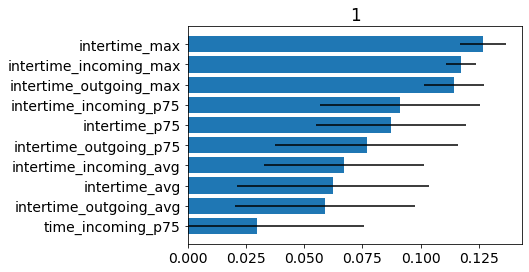

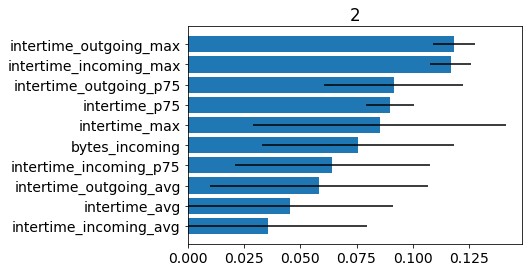

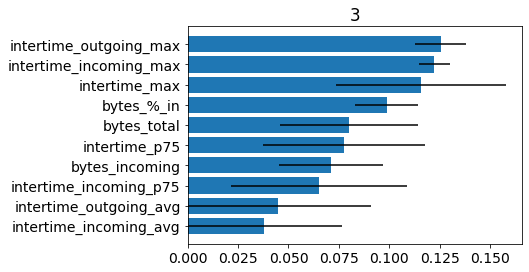

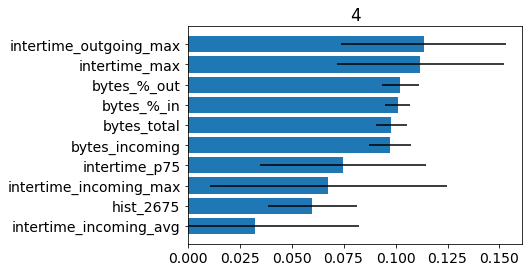

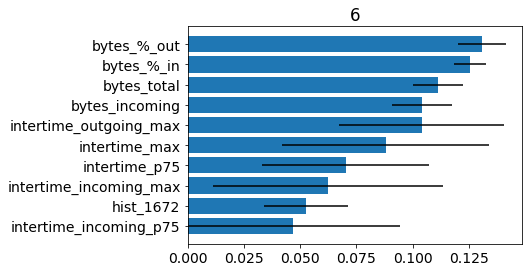

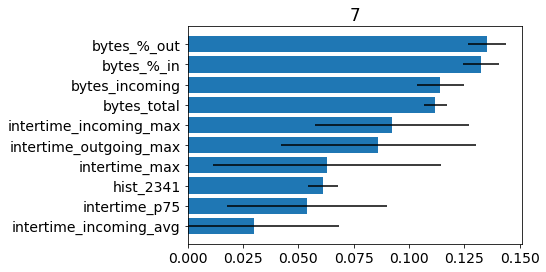

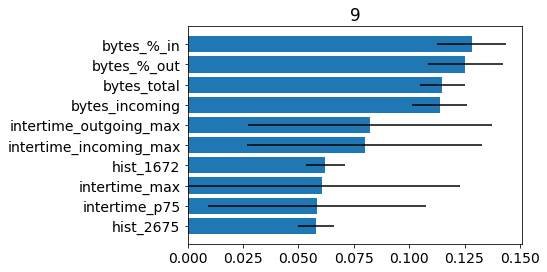

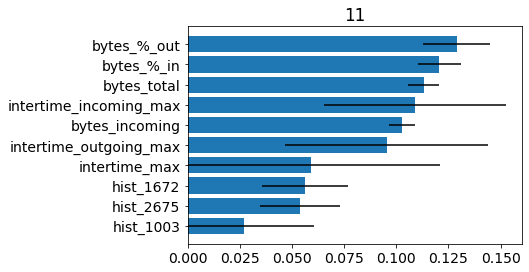

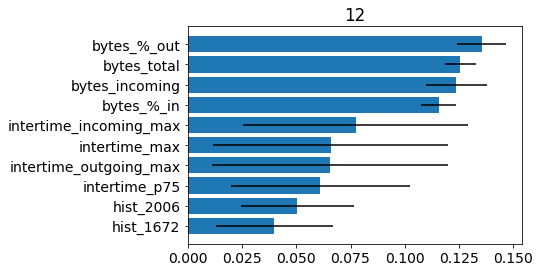

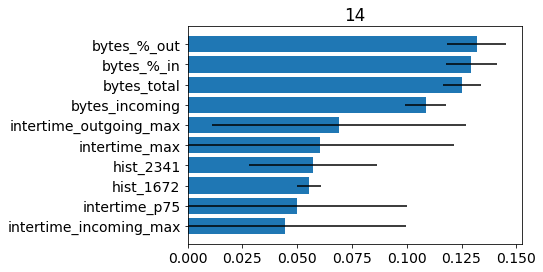

Padding function steps: 1, mean extra cost per subresource 150 kB, accuracy 0.44, top features: ['intertime_max', 'intertime_incoming_p75', 'intertime_incoming_max']
Padding function steps: 2, mean extra cost per subresource 68 kB, accuracy 0.57, top features: ['bytes_incoming', 'intertime_outgoing_max', 'intertime_max']
Padding function steps: 3, mean extra cost per subresource 40 kB, accuracy 0.65, top features: ['intertime_outgoing_max', 'intertime_max', 'intertime_incoming_max']
Padding function steps: 4, mean extra cost per subresource 27 kB, accuracy 0.71, top features: ['intertime_outgoing_max', 'intertime_max', 'bytes_%_out']
Padding function steps: 6, mean extra cost per subresource 19 kB, accuracy 0.77, top features: ['bytes_%_in', 'bytes_%_out', 'bytes_incoming']
Padding function steps: 7, mean extra cost per subresource 14 kB, accuracy 0.77, top features: ['bytes_%_out', 'bytes_%_in', 'bytes_incoming']
Padding function steps: 9, mean extra cost per subresource 11 kB, accura

In [20]:
import numpy as np
import scikitplot as skplt

def plot_fi(features_of_interest, title):
    features_of_interest.sort(key=lambda row: row[1], reverse=True) # truncate top ten
    features_of_interest = features_of_interest[:10]
    features_of_interest.sort(key=lambda row: row[1], reverse=False) # plotting needs ascending order

    xs = [x[0] for x in features_of_interest]
    ys = [y[1] for y in features_of_interest]
    yerr = [[min(y[1], y[2]) for y in features_of_interest], [y[2] for y in features_of_interest]]

    plt.barh(xs, ys, xerr=yerr)
    plt.title(title)
    plt.show()
    

txt = ""
last_size = 0

to_plot = []

for cuts, mean_cost in padding_functions:

    if not len(cuts) in clf_perf: # if the attack was not run, skip
        continue
    if len(cuts) == last_size: # skips repeat due to rounding in np.linrange
        continue

    last_size = len(cuts)
    acc = round(clf_perf[len(cuts)]['score']['accuracy'][0], 2)
    top_f = [feature_name for feature_name, *_ in clf_perf[len(cuts)]['features'][:3]]
    mean_cost_str = f"{round(mean_cost)} B"
    if mean_cost > 1024:
        mean_cost_str = f"{round(mean_cost/1024)} kB"
    txt += f"Padding function steps: {len(cuts)}, mean extra cost per subresource {mean_cost_str}, accuracy {acc}, top features: {top_f}\n"
    

    to_plot.append([len(cuts), mean_cost, acc])


    if len(cuts) < 15:
        plot_fi(clf_perf[len(cuts)]['features'], title=len(cuts))

print(txt)
with open("pad-cost-vs-acc.txt", 'w') as f:
    f.write(txt)

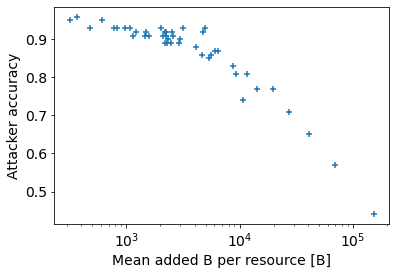

In [21]:
len_cuts = [row[0] for row in to_plot]
mean_costs = [row[1] for row in to_plot]
accs = [row[2] for row in to_plot]

plt.scatter(mean_costs, accs, marker="+")
plt.ylabel("Attacker accuracy")
plt.xlabel("Mean added B per resource [B]")
plt.xscale('log')

In [22]:
# Dive deep in 15 cuts - 60%

cuts, mean_cost = find_optimal_pad(incoming_bytes, 15)
data_padded = pad_to_cuts(data_matching, cuts)
features = get_features(data_padded)
clf_res = rf_with_rfe(features)

[feature_extract] Number of classes 10
[feature_extract] Number of features 123
[feature_extract] Number of samples 391
[feature_extract] Number of labels 391
Number of classes 10
Number of features 123
Number of samples 391
Number of labels 391
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9


['bytes_%_out', 'bytes_%_in', 'bytes_incoming', 'intertime_incoming_max', 'bytes_total']


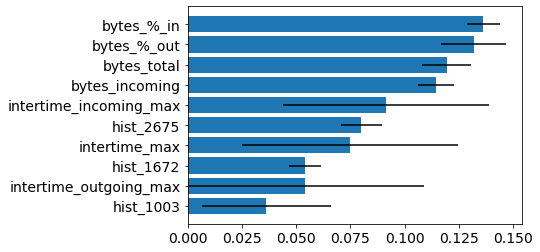

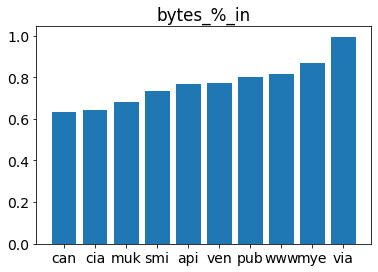

[['canadagoosebuy.ca', 0.6327562696951652, 0.008797150601759495], ['cialisdr.com', 0.6410711267602459, 0.006318460170478409], ['muk-toon.com', 0.6795154062589468, 0.0033464408270760574], ['smileytoysandgames.com', 0.735345033201727, 0.019956128523604476], ['apiexpossandbox.mile.app', 0.7692862603241793, 0.0021827298012704194], ['venona.com', 0.7706680991466068, 0.015280783677694903], ['publyads.jstag.space', 0.8003240042092152, 0.01328736332473549], ['www.thaitoon.net', 0.8172292489143476, 0.0074028220897356155], ['myegypthost.com', 0.8681205837708805, 0.02407507797337949], ['viaagra1.com', 0.9942436912002117, 1.7769564637089382e-06]]


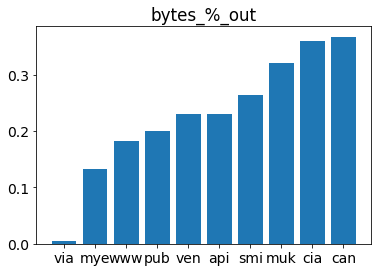

[['viaagra1.com', 0.0057563087997885105, 1.7769564637089058e-06], ['myegypthost.com', 0.13187941622911956, 0.024075077973379478], ['www.thaitoon.net', 0.18277075108565244, 0.007402822089735614], ['publyads.jstag.space', 0.19967599579078482, 0.013287363324735495], ['venona.com', 0.22933190085339314, 0.015280783677694903], ['apiexpossandbox.mile.app', 0.23071373967582062, 0.002182729801270418], ['smileytoysandgames.com', 0.26465496679827316, 0.019956128523604476], ['muk-toon.com', 0.3204845937410531, 0.0033464408270760583], ['cialisdr.com', 0.3589288732397539, 0.00631846017047841], ['canadagoosebuy.ca', 0.36724373030483476, 0.008797150601759491]]


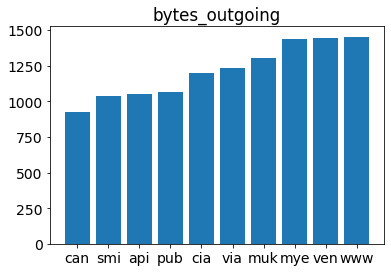

[['canadagoosebuy.ca', 923.0769230769231, 200236.68639053253], ['smileytoysandgames.com', 1035.0, 683775.0], ['apiexpossandbox.mile.app', 1050.0, 355500.0], ['publyads.jstag.space', 1065.0, 134775.0], ['cialisdr.com', 1200.0, 0.0], ['viaagra1.com', 1230.7692307692307, 17514.792899408276], ['muk-toon.com', 1305.0, 231975.0], ['myegypthost.com', 1433.3333333333333, 85555.55555555556], ['venona.com', 1446.1538461538462, 160946.74556213018], ['www.thaitoon.net', 1452.6315789473683, 428808.8642659279]]


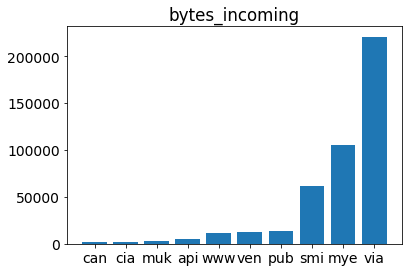

[['canadagoosebuy.ca', 1721.7948717948718, 776280.9835634452], ['cialisdr.com', 2338.15, 793514.3775], ['muk-toon.com', 2969.0, 1648202.5], ['apiexpossandbox.mile.app', 5034.475, 71018670.199375], ['www.thaitoon.net', 11726.71052631579, 179255091.88988924], ['venona.com', 12580.897435897436, 230746611.98948064], ['publyads.jstag.space', 13548.6, 273036368.04], ['smileytoysandgames.com', 61837.9, 16097952609.240002], ['myegypthost.com', 105777.02777777778, 6736093471.86034], ['viaagra1.com', 220766.71794871794, 1624322001.946088]]


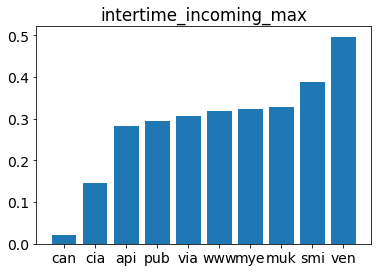

[['canadagoosebuy.ca', 0.021102564102564104, 0.0016979894806048652], ['cialisdr.com', 0.145125, 0.0023812093749999994], ['apiexpossandbox.mile.app', 0.282625, 0.058559984375000006], ['publyads.jstag.space', 0.29355000000000003, 0.0614653975], ['viaagra1.com', 0.3068717948717948, 0.008786624589086127], ['www.thaitoon.net', 0.31826315789473686, 0.02923124653739612], ['myegypthost.com', 0.32430555555555557, 0.010668212191358025], ['muk-toon.com', 0.328375, 0.04379573437499999], ['smileytoysandgames.com', 0.38862499999999994, 0.672212584375], ['venona.com', 0.4970512820512821, 0.03247066403681789]]


In [23]:
def find_pos(name, feature_names):
    i = 0
    while i<len(feature_names):
        if feature_names[i].strip() == name:
            return i
        i += 1
    print("Couldn't find", name)
    sys.exit(0)

def isolate_feature(name, features):
    pos = find_pos(name, features['feature_names'])
    extracted_features = [row[pos] for row in features['features']]
    labels = [row[0] for row in features['labels']]
    labels_feat = zip(labels, extracted_features)

    # group by first elements
    res = dict()
    for label, feature in zip(labels, extracted_features):
        if not label in res:
            res[label] = []
        res[label].append(feature)

    # -> mean/var
    res2 = dict()
    for label in res:
        res2[label] = [np.mean(res[label]), np.var(res[label])]

    tuples = list(res2.items())
    tuples = [[t[0], t[1][0], t[1][1]] for t in tuples]

    # sort by mean feature
    tuples.sort(key=lambda row: row[1])

    xs = [row[0][:3] for row in tuples]
    ys = [row[1] for row in tuples]
    ys_err = [row[2] for row in tuples]
    i_s = np.arange(len(ys))

    plt.bar(i_s, ys)
    plt.title(name)
    plt.xticks(i_s, xs)
    plt.show()
    print(tuples)

# top features
features_of_interest = clf_perf[len(cuts)]['features']
print([feature_name for feature_name, *_ in features_of_interest[:5]])

import numpy as np
import scikitplot as skplt

features_of_interest.sort(key=lambda row: row[1], reverse=True) # truncate top ten
features_of_interest = features_of_interest[:10]
features_of_interest.sort(key=lambda row: row[1], reverse=False) # plotting needs ascending order

xs = [x[0] for x in features_of_interest]
ys = [y[1] for y in features_of_interest]
yerr = [[min(y[1], y[2]) for y in features_of_interest], [y[2] for y in features_of_interest]]

plt.barh(xs, ys, xerr=yerr)
plt.show()

isolate_feature('bytes_%_in', features)
isolate_feature('bytes_%_out', features)
isolate_feature('bytes_outgoing', features)
isolate_feature('bytes_incoming', features)
isolate_feature('intertime_incoming_max', features)




['n_incoming', 'n_outgoing', 'n_total', '%_in', '%_out', 'bytes_incoming', 'bytes_outgoing', 'bytes_total', 'bytes_%_in', 'bytes_%_out', 'intertime_incoming_max', 'intertime_incoming_avg', 'intertime_incoming_std', 'intertime_incoming_p75', 'intertime_outgoing_max', 'intertime_outgoing_avg', 'intertime_outgoing_std', 'intertime_outgoing_p75', 'intertime_max', 'intertime_avg', 'intertime_std', 'intertime_p75', 'time_incoming_p25', 'time_incoming_p50', 'time_incoming_p75', 'time_incoming_p100', 'time_outgoing_p25', 'time_outgoing_p50', 'time_outgoing_p75', 'time_outgoing_p100', 'time_p25', 'time_p50', 'time_p75', 'time_p100', 'times_sum', 'f30_n_incoming', 'f30_n_outgoing', 'l30_n_incoming', 'l30_n_outgoing', 'delta_rate_avg', 'delta_rate_std', 'delta_rate_p50', 'delta_rate_min', 'delta_rate_max', 'delta_rate_1', 'delta_rate_2', 'delta_rate_3', 'delta_rate_4', 'delta_rate_5', 'delta_rate_6', 'delta_rate_7', 'delta_rate_8', 'delta_rate_9', 'delta_rates_20_0', 'delta_rates_20_1', 'delta_ra

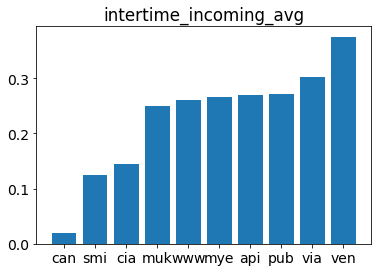

[['canadagoosebuy.ca', 0.018923076923076924, 0.001523929980276134], ['smileytoysandgames.com', 0.12484999999999999, 0.06379763861111111], ['cialisdr.com', 0.145125, 0.0023812093749999994], ['muk-toon.com', 0.24947499999999997, 0.029790199375], ['www.thaitoon.net', 0.2599830827067669, 0.020540503070410988], ['myegypthost.com', 0.26643055555555556, 0.003458543788580247], ['apiexpossandbox.mile.app', 0.26895416666666666, 0.056963990260416666], ['publyads.jstag.space', 0.270575, 0.05106908187499999], ['viaagra1.com', 0.30302564102564095, 0.008555358316896777], ['venona.com', 0.37512820512820516, 0.02574123997370152]]


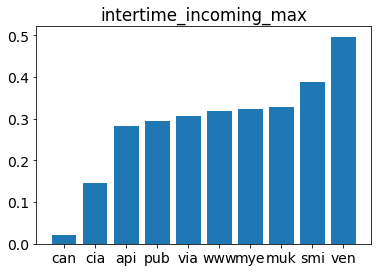

[['canadagoosebuy.ca', 0.021102564102564104, 0.0016979894806048652], ['cialisdr.com', 0.145125, 0.0023812093749999994], ['apiexpossandbox.mile.app', 0.282625, 0.058559984375000006], ['publyads.jstag.space', 0.29355000000000003, 0.0614653975], ['viaagra1.com', 0.3068717948717948, 0.008786624589086127], ['www.thaitoon.net', 0.31826315789473686, 0.02923124653739612], ['myegypthost.com', 0.32430555555555557, 0.010668212191358025], ['muk-toon.com', 0.328375, 0.04379573437499999], ['smileytoysandgames.com', 0.38862499999999994, 0.672212584375], ['venona.com', 0.4970512820512821, 0.03247066403681789]]


In [24]:
# we "fixed" the incoming bytes with padding
# let's ignore the outgoing bytes for now

print(features['feature_names'])

isolate_feature('intertime_incoming_avg', features)
isolate_feature('intertime_incoming_max', features)

1 0 1.0000000000000002 0 0
2 0.13490999162436382 0.8650900083756363 0 0
3 0.2734719473790603 0.714089275654033 0 0.012438776966906748
4 0.39840912341050516 0.5297009446750621 0 0.0718899319144328
6 0.471681203313154 0.4467233202553711 0 0.08159547643147495
6 0.471681203313154 0.4467233202553711 0 0.08159547643147495
7 0.4935862858208992 0.44114386010761775 0 0.06526985407148309
9 0.48245756793513295 0.3639532757091512 0 0.1535891563557159
9 0.48245756793513295 0.3639532757091512 0 0.1535891563557159
11 0.46550276318232536 0.3837903630073236 0 0.15070687381035106
12 0.5001884485712091 0.396776043774346 0 0.1030355076544448
12 0.5001884485712091 0.396776043774346 0 0.1030355076544448
14 0.49521136752433503 0.3429592364564371 0 0.1618293960192278
14 0.49521136752433503 0.3429592364564371 0 0.1618293960192278
16 0.5014804985769383 0.32377679773757423 0 0.17474270368548744
17 0.5235871993224461 0.30190746590081063 0 0.17450533477674335
18 0.5299536012068253 0.3048037437456568 0 0.1652426550

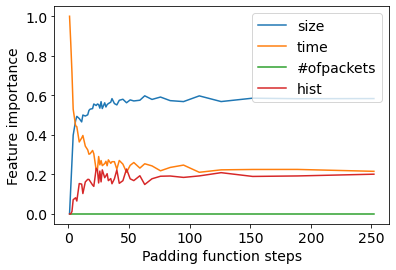

In [25]:
# understand how features evolve

def find_importance(features_and_importance, feature_name):
    for feature, importance, _ in features_and_importance:
        if feature == feature_name:
            return importance

    return 0

def sum_all_matching(features_and_importance, keyword):
    su = 0
    for feature, importance, _ in features_and_importance:
        if keyword in feature:
            su += importance

    return su

tuples = []


for cuts, mean_cost in padding_functions:

    if not len(cuts) in clf_perf: # if the attack was not run, skip
        continue

    features = clf_perf[len(cuts)]['features']


    print(len(cuts), sum_all_matching(features, "byte"), sum_all_matching(features, "time"), sum_all_matching(features, "n_"), sum_all_matching(features, "hist"))

    tuples.append([len(cuts), sum_all_matching(features, "byte"), sum_all_matching(features, "time"), sum_all_matching(features, "n_"), sum_all_matching(features, "hist")])

xs = [t[0] for t in tuples]
ys1 = [t[1] for t in tuples]
ys2 = [t[2] for t in tuples]
ys3 = [t[3] for t in tuples]
ys4 = [t[4] for t in tuples]

plt.subplot(1, 1, 1)
plt.plot(xs, ys1, label="size")
plt.plot(xs, ys2, label="time")
plt.plot(xs, ys3, label="#ofpackets")
plt.plot(xs, ys4, label="hist")
plt.xlabel("Padding function steps")
plt.ylabel("Feature importance")
plt.legend(loc='upper right')
plt.show()
    

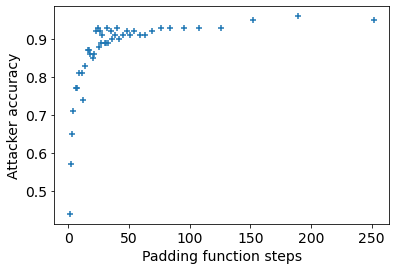

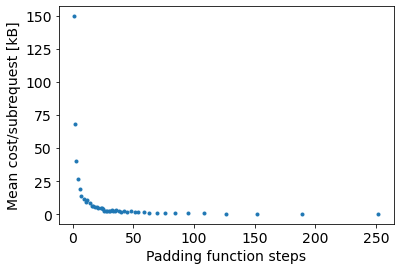

In [26]:
to_plot = []

for cuts, mean_cost in padding_functions:

    if not len(cuts) in clf_perf: # if the attack was not run, skip
        continue
    if len(cuts) == last_size: # skips repeat due to rounding in np.linrange
        continue

    last_size = len(cuts)
    acc = round(clf_perf[len(cuts)]['score']['accuracy'][0], 2)
    top_f = [feature_name for feature_name, *_ in clf_perf[len(cuts)]['features'][:3]]
    mean_cost_str = f"{round(mean_cost)} B"
    if mean_cost > 1024:
        mean_cost_str = f"{round(mean_cost/1024)} kB"
    txt += f"Padding function steps: {len(cuts)}, mean extra cost per subresource {mean_cost_str}, accuracy {acc}, top features: {top_f}\n"
    

    to_plot.append([len(cuts), mean_cost, acc])

len_cuts = [row[0] for row in to_plot]
mean_costs = [row[1]/1024 for row in to_plot]
accs = [row[2] for row in to_plot]

plt.scatter(len_cuts, accs, marker="+")
plt.ylabel("Attacker accuracy")
plt.xlabel("Padding function steps")
plt.show()
plt.scatter(len_cuts, mean_costs, marker=".")
plt.ylabel("Mean cost/subrequest [kB]")
plt.xlabel("Padding function steps")
plt.show()